<a href="https://colab.research.google.com/github/ekrell/ams_ai_shortcourse_2024/blob/main/modules/preprocessing_exploring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMS AI Short Course: Data Analysis & Preprocessing

**Credit:** this notebook is a modification of the one used for the [AMS 2019 ML Python Course](https://github.com/djgagne/ams-ml-python-course/blob/master/module_1/ML_Short_Course_Module_1_data_analysis_and_preproc.ipynb).

This notebook focuses on:

1. Wrangling tabular and gridded datasets
2. Investigating your data through visualization

It does not focus on:

1. Data cleaning (e.g. dealing with missing values)

# Setup Environment

In [1]:
# Install software libraries
!pip install netCDF4
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 15.3 MB/s eta 0:00:00


In [2]:
# Import libraries
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import percentileofscore
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import os
from os.path import exists, join
import time
from urllib.request import urlretrieve
import tarfile

# Dataset

## Description

**Tornado Prediction**

The goal of the problem is to predict the probability of low-level vorticity exceeding a certain threshold up to ahead given a storm with a simulated radar reflectivity > 40 dBZ and the associated surface wind and temperature fields.

- Input fields in the netCDF data:
  - `REFL_COM_curr` ([composite reflectivity](https://en.wikipedia.org/wiki/Composite_reflectivity))
  - `U10_curr` (10 m west-east wind component in m/s)
  - `V10_curr` (10 m south-north wind component in m/s)
  - `T2_curr` (2 m temperature in Kelvin)
- Prediction field:
  - `RVORT1_MAX_future` (hourly maximum vertical vorticity at 1 km Above ground level in s-1)


**Two data formats:**

1. **Tabular `.csv` files:** plaintext files that contain tabular data
2. **Gridded (raster) `.nc` files:** NetCDF (network Common Data Form) is a file format designed for multidimensional variables. These files contain variables of arbitrary dimensions, so the files also contain metadata with the units, resolutions, etc for each variable. Commonly, all variables have consistent `time` and `x`, `y` dimensions for indexing them easily.

These two datasets are complementary. They have the same number of samples so that each tabular row contains features for the correspinding storm track image.

## Download

In [3]:
if not exists("data"):
    os.mkdir("data")

csv_tar_file = "https://storage.googleapis.com/track_data_ncar_ams_3km_csv_small/track_data_ncar_ams_3km_csv_small.tar.gz"
nc_tar_file = "https://storage.googleapis.com/track_data_ncar_ams_3km_nc_small/track_data_ncar_ams_3km_nc_small.tar.gz"

print("Get csv files")
urlretrieve(csv_tar_file, join("data", csv_tar_file.split("/")[-1]))

print("Get nc files")
urlretrieve(nc_tar_file, join("data", nc_tar_file.split("/")[-1]))

print("Extract csv tar file")
csv_tar = tarfile.open(join("data", csv_tar_file.split("/")[-1]))
csv_tar.extractall("data/")
csv_tar.close()

print("Extract nc tar file")
nc_tar = tarfile.open(join("data", nc_tar_file.split("/")[-1]))
nc_tar.extractall("data/")
nc_tar.close()

Get csv files
Get nc files
Extract csv tar file
Extract nc tar file


In [4]:
# Check our downloads
!ls data

track_data_ncar_ams_3km_csv_small	  track_data_ncar_ams_3km_nc_small
track_data_ncar_ams_3km_csv_small.tar.gz  track_data_ncar_ams_3km_nc_small.tar.gz


# Tabular Data Example

How to find the CSV files and create a sorted list of the found files

To do this, we use the glob library to list all of the *.csv files in the specified directory.

In [5]:
# set the path to the data as a string
path = "data/track_data_ncar_ams_3km_csv_small/"

# create a list of the files and print it out
files = sorted(glob.glob(path+"/*.csv"))

# Show first 5
files[:5]

['data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv',
 'data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv',
 'data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv',
 'data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv',
 'data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv']

How to read in all of the found CSV files using Pandas and concat all of the content

This method adds the content of all of the csv files into one Python Pandas DataFrame object. We also print the data's column labels in order to help us determine which keys we can use.

In [6]:
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
print(df.keys())

Index(['Step_ID', 'Track_ID', 'Ensemble_Name', 'Ensemble_Member', 'Run_Date',
       'Valid_Date', 'Forecast_Hour', 'Valid_Hour_UTC', 'Duration',
       'Centroid_Lon', 'Centroid_Lat', 'Centroid_X', 'Centroid_Y',
       'Storm_Motion_U', 'Storm_Motion_V', 'REFL_COM_mean', 'REFL_COM_max',
       'REFL_COM_min', 'REFL_COM_std', 'REFL_COM_percentile_10',
       'REFL_COM_percentile_25', 'REFL_COM_percentile_50',
       'REFL_COM_percentile_75', 'REFL_COM_percentile_90', 'U10_mean',
       'U10_max', 'U10_min', 'U10_std', 'U10_percentile_10',
       'U10_percentile_25', 'U10_percentile_50', 'U10_percentile_75',
       'U10_percentile_90', 'V10_mean', 'V10_max', 'V10_min', 'V10_std',
       'V10_percentile_10', 'V10_percentile_25', 'V10_percentile_50',
       'V10_percentile_75', 'V10_percentile_90', 'T2_mean', 'T2_max', 'T2_min',
       'T2_std', 'T2_percentile_10', 'T2_percentile_25', 'T2_percentile_50',
       'T2_percentile_75', 'T2_percentile_90', 'RVORT1_MAX-future_mean',
       'RVOR

## Explore `.csv` files

It's always important to understand your data before you do anything with it! If you don't understand your data, your analysis will be difficult and conclusions can be incorrect.

First lets get a subsection of the data into a `DataFrame` object by using the labels found by printing the list of keys.

In [7]:
df1 = df.loc[:,['Step_ID', 'U10_mean', 'V10_mean', 'T2_mean']]
df1.head()

,Step_ID,U10_mean,V10_mean,T2_mean
0,d01_REFL_COM_20101024-0000_12_12_000_00,0.19710,5.32790,293.14920
1,d01_REFL_COM_20101024-0000_12_12_001_00,-1.03154,5.33612,292.00092
2,d01_REFL_COM_20101024-0000_12_15_002_00,-0.21393,1.99015,293.00864
3,d01_REFL_COM_20101024-0000_12_15_002_01,1.27862,1.81628,292.64368
4,d01_REFL_COM_20101024-0000_12_15_002_02,0.88129,4.33189,292.39392


You can explore the data in various ways.

How many samples are in the dataset?

In [8]:
print("Number of rows: " + str(len(df1)))

Number of rows: 121137


Commands built into `Pandas` can provide a plethora of information

In [9]:
df1.describe()

,U10_mean,V10_mean,T2_mean
count,121137.000000,121137.00000,121137.000000
mean,0.327331,0.36504,289.465444
std,4.251063,4.51375,6.963805
min,-18.653700,-24.14743,262.921600
25%,-2.449740,-2.48763,285.292210
50%,0.274450,0.49327,290.714110
75%,3.085180,3.35748,294.436310
max,19.686640,18.61693,314.625730


Using plotting libraries like `matplotlib`, `seaborn` and `plotly`, we can create graphics using the tabular data.

But `Pandas` provides a few very common visualizations itself (by using `matplotlib` behind the scenes as its plotting backend)

array([[<Axes: title={'center': 'U10_mean'}>,
        <Axes: title={'center': 'V10_mean'}>],
       [<Axes: title={'center': 'T2_mean'}>, <Axes: >]], dtype=object)

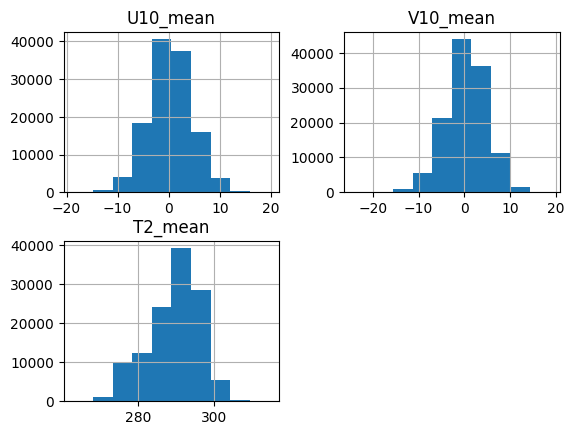

In [10]:
df1.hist()

We can easily produce a boxplot..

<Axes: >

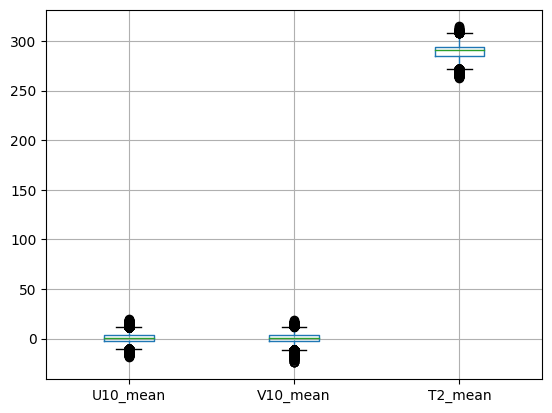

In [11]:
df1.boxplot()

But the above is not satisfactory since `T2_mean` has a very different range of values. They box plots are squished.

Two separate boxplots is preferred.

<Axes: >

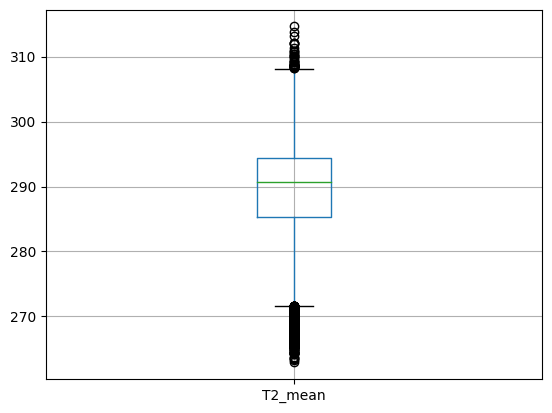

In [12]:
df1.boxplot("T2_mean")

<Axes: >

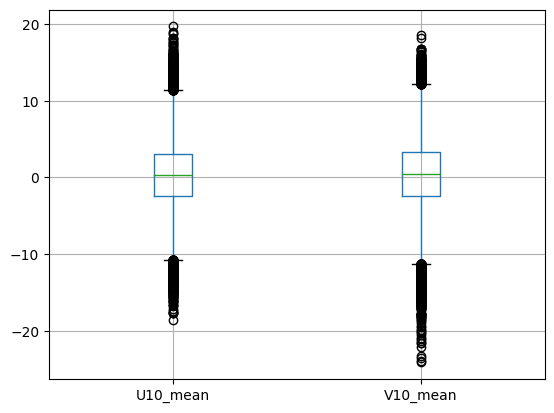

In [13]:
df1.boxplot(["U10_mean", "V10_mean"])

We can plot the values directly.

Since `pandas` plotting is really using `matplotlib` as the plotting engine, we can continue to modify the plots using the `matplotlib` library.

Text(0, 0.5, 'Temperature')

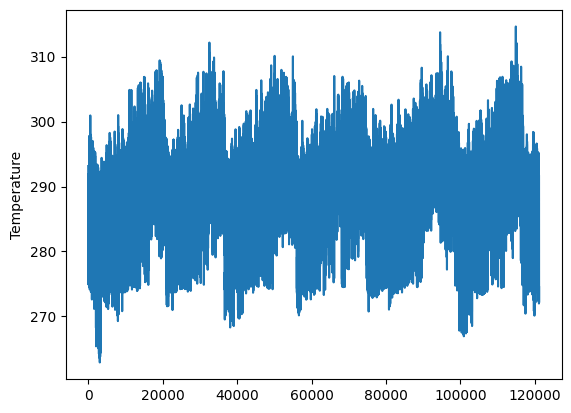

In [14]:
df1['T2_mean'].plot()
plt.ylabel("Temperature")

And, by using geospatial libraries like `cartopy`, we place data in their spatial context by making a map

Text(0.5, 1.0, 'Tornadic Storm Spatial Frequency')

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


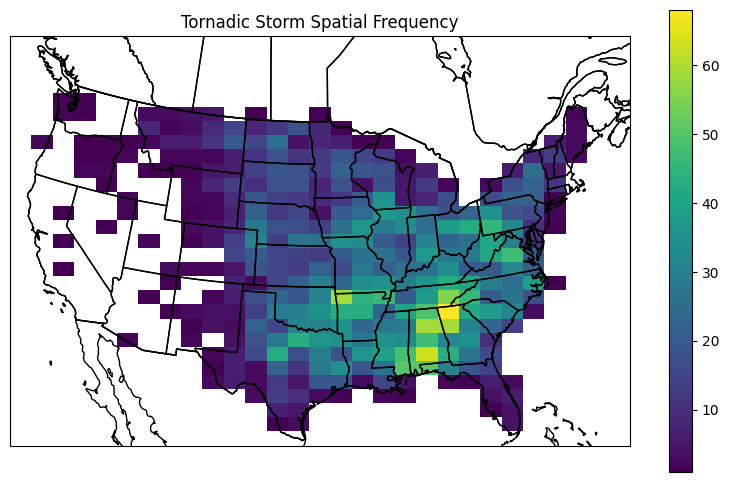

In [15]:
# Specify the map projection
proj = ccrs.LambertConformal()

# For more custom plotting, we first build a figure
fig = plt.figure(figsize=(10, 6))
# And modify its axes
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add basemap information to add spatial context
countries = cfeature.NaturalEarthFeature("cultural", "admin_0_countries", "50m", facecolor="None", edgecolor="k")
states = cfeature.NaturalEarthFeature("cultural", "admin_1_states_provinces", "50m", facecolor="None", edgecolor="k")
ax.add_feature(countries)
ax.add_feature(states)

# Select storms with a vorticity threshold  (tornadic storms)
tor_idx = df["RVORT1_MAX-future_max"] > 0.005

# The coordinates need to match the map's projection
out_points = proj.transform_points(ccrs.PlateCarree(),
                            df.loc[tor_idx, "Centroid_Lon"].values, df.loc[tor_idx, "Centroid_Lat"].values)

# Plot a 2D histogram to highlight where the storms are
out = ax.hist2d(out_points[:, 0], out_points[:, 1], bins=(np.linspace(-2.5e6, 2.5e6, 30),
                                                          np.linspace(-1.5e6, 1.8e6, 30)), cmin=1)

# Only show the relevant region (we'll automate this later)
ax.set_extent([-2.5e6, 2.5e6, -1.5e6, 1.8e6], crs=proj)

# Add a colorbar & title
plt.colorbar(out[-1])
plt.title("Tornadic Storm Spatial Frequency")

# Raster Data Example

How to find the NetCDF files and create a sorted list of the found files

To do this, we use the glob library to list all of the *.nc files in the specified directory.

In [16]:
# Local path to directory with the extracted nc files
path = "data/track_data_ncar_ams_3km_nc_small/"

# Create a list of the files and print it out
files = sorted(glob.glob(path+"/*.nc"))

# Print first N files
N = 5
files[:5]

['data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc',
 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc',
 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc',
 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc',
 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc']

## Explore NetCDF files


Let's read in the first file in the list and see what is in the files.

In the below cell, we open the first file within the file list and print out its summary information. Afterwards, we close the file.

In [17]:
#  Open the file with the Netcdf library for reading and then close it
nf = nc.Dataset(files[0], "r")
print (nf)
nf.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    title: NCARSTORM Storm Patches for run 20101024-0000 member d01
    object_variable: REFL_COM
    dimensions(sizes): p(1472), row(32), col(32)
    variables(dimensions): int32 p(p), int32 row(row), int32 col(col), float32 lon(p, row, col), float32 lat(p, row, col), int32 i(p, row, col), int32 j(p, row, col), float32 x(p, row, col), float32 y(p, row, col), int32 masks(p, row, col), int32 time(p), float32 centroid_lon(p), float32 centroid_lat(p), float32 centroid_i(p), float32 centroid_j(p), int32 track_id(p), int32 track_step(p), float32 REFL_COM_curr(p, row, col), float32 U10_curr(p, row, col), float32 V10_curr(p, row, col), float32 T2_curr(p, row, col), float32 RVORT1_MAX_future(p, row, col), float32 HAIL_MAXK1_future(p, row, col)
    groups: 


Now lets open a file with `xarray` and print its content

As you probably have noticed, the output format is easier to read.

**Note:** below, the `p` dimension refers to `patches`. These images are called storm patches, so `p` simply indexes each sample.

In [18]:
xf = xr.open_dataset(files[0])
print (xf)

<xarray.Dataset>
Dimensions:            (p: 1472, row: 32, col: 32)
Coordinates:
  * p                  (p) int32 0 1 2 3 4 5 6 ... 1466 1467 1468 1469 1470 1471
  * row                (row) int32 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * col                (col) int32 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
Data variables: (12/20)
    lon                (p, row, col) float32 ...
    lat                (p, row, col) float32 ...
    i                  (p, row, col) int32 ...
    j                  (p, row, col) int32 ...
    x                  (p, row, col) float32 ...
    y                  (p, row, col) float32 ...
    ...                 ...
    REFL_COM_curr      (p, row, col) float32 ...
    U10_curr           (p, row, col) float32 ...
    V10_curr           (p, row, col) float32 ...
    T2_curr            (p, row, col) float32 ...
    RVORT1_MAX_future  (p, row, col) float32 ...
    HAIL_MAXK1_future  (p, row, col) float32 ...
Attributes:
    Conventions:      CF-1.6

Here are a few different ways to look at the different parts of a NetCDF file using xarray

You can reference variables as keys within the xarray object.

You can use the variable's attributes to reference the dimensions, coordinates, and attributes of that variable.

(The number of instances `p` is much less than the number of rows in our table. Remember, this is just one file among many!)

In [19]:
T = xf['T2_curr']
print (T)
print("---------")
print ("Dimensions:", T.dims)
print ("Coords:", T.coords)
print ("Attributes:", T.attrs)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
[1507328 values with dtype=float32]
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
Attributes:
    long_name:  T2
    units:      
---------
Dimensions: ('p', 'row', 'col')
Coords: Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
Attributes: {'long_name': 'T2', 'units': ''}



Indexing and Selecting Data Ranges

There are difference ways to retrieve the values of a variable.

You can use indexing similar to `numpy` arrays. You can also index using diminsion names.

In [20]:
# Numpy-style (order matters)
print(T[0,0,1].values)
print(T[0:5,0,1].values)

# Using select to explicity declare the coordinates
print(T.sel(p=4,col=1,row=0).values)
print(T.sel(row=0,col=1,p=4).values)
print(T.sel(p=slice(0,5),col=1,row=0).values)

293.50546
[293.50546 293.06808 294.17676 294.1718  292.86124]
292.86124
292.86124
[293.50546 293.06808 294.17676 294.1718  292.86124 293.2119 ]


## Data transformations

For these examples, we will use the `xarray` object

Create an array where the values are larger than 290 and values less than 290 are added as nan values.

In [21]:
T.where(T>290)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[293.5103 , 293.50546, 292.88248, ..., 292.40265, 292.29697,
         292.0353 ],
        [293.73416, 293.6699 , 293.5675 , ..., 292.40796, 292.3496 ,
         292.35492],
        [293.88092, 293.71262, 293.7029 , ..., 292.30725, 292.34692,
         292.33405],
        ...,
        [295.4044 , 295.70648, 294.7517 , ..., 291.87216, 291.9213 ,
         291.8481 ],
        [295.75235, 295.77435, 294.63358, ..., 291.7682 , 292.0231 ,
         291.988  ],
        [295.861  , 294.75845, 294.55954, ..., 291.89066, 291.97015,
         292.3123 ]],

       [[293.1342 , 293.06808, 293.12137, ..., 291.3755 , 291.42545,
         291.39578],
        [293.092  , 293.06543, 293.0489 , ..., 291.3205 , 291.25757,
         291.27454],
        [293.20197, 293.20743, 293.23752, ..., 291.25165, 291.1832 ,
         291.1835 ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
Attributes:
    long_name:  T2
    units:

Create an array where values greater than 290 are True and values less than 290 are False


In [22]:
T>290

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31

Round all values to the nearest integer

In [23]:
T.round(0)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[294., 294., 293., ..., 292., 292., 292.],
        [294., 294., 294., ..., 292., 292., 292.],
        [294., 294., 294., ..., 292., 292., 292.],
        ...,
        [295., 296., 295., ..., 292., 292., 292.],
        [296., 296., 295., ..., 292., 292., 292.],
        [296., 295., 295., ..., 292., 292., 292.]],

       [[293., 293., 293., ..., 291., 291., 291.],
        [293., 293., 293., ..., 291., 291., 291.],
        [293., 293., 293., ..., 291., 291., 291.],
        ...,
        [292., 292., 292., ..., 293., 292., 292.],
        [292., 292., 292., ..., 293., 292., 292.],
        [292., 292., 292., ..., 292., 292., 292.]],

       [[294., 294., 294., ..., 292., 292., 292.],
        [294., 294., 294., ..., 292., 292., 292.],
        [294., 294., 294., ..., 292., 292., 292.],
        ...,
...
        ...,
        [280., 280., 280., ..., 283., 283., 283.],
        [280., 280., 280., ..., 283., 283., 283.],
        [280., 280., 280., ..., 283., 283., 283.]],

       [[284., 284., 283., ..., 283., 285., 285.],
        [285., 285., 284., ..., 283., 285., 285.],
        [285., 285., 285., ..., 284., 285., 285.],
        ...,
        [286., 286., 286., ..., 282., 283., 283.],
        [286., 286., 286., ..., 282., 282., 283.],
        [286., 286., 286., ..., 283., 282., 283.]],

       [[278., 279., 281., ..., 273., 275., 276.],
        [279., 281., 281., ..., 273., 274., 275.],
        [280., 281., 281., ..., 275., 275., 275.],
        ...,
        [283., 283., 283., ..., 276., 277., 276.],
        [283., 283., 284., ..., 277., 279., 279.],
        [283., 284., 285., ..., 279., 281., 281.]]], dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
Attributes:
    long_name:  T2
    units:

Find the mean of all the values for that variable

In [24]:
T.mean(dim=['col','row','p']).values

array(285.3192, dtype=float32)

Find the min of all values for that variable and then find the min across all columns and rows

In [25]:
print (T.min())
print (T.min(dim=['col','row']))

<xarray.DataArray 'T2_curr' ()>
array(261.8042, dtype=float32)
<xarray.DataArray 'T2_curr' (p: 1472)>
array([291.46454, 290.80118, 291.36282, ..., 279.1897 , 277.76544,
       263.59863], dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471


Find the max of all values for that variable and then find the min across all columns and rows

In [26]:
print (T.max())
print (T.max(dim=['col','row']))

<xarray.DataArray 'T2_curr' ()>
array(303.61737, dtype=float32)
<xarray.DataArray 'T2_curr' (p: 1472)>
array([296.53342, 295.33218, 295.74823, ..., 284.14084, 286.5378 ,
       285.0278 ], dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471


## Exploratory Visualization

How to create a simple line plot using the `matplotlib` library

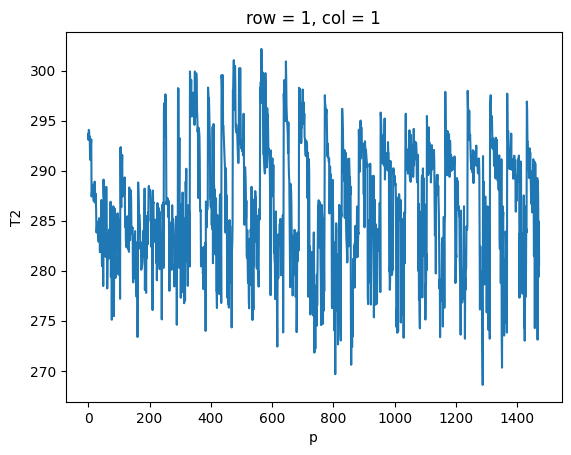

In [27]:
T[:,1,1].plot()

How to create a simple plot of p=0

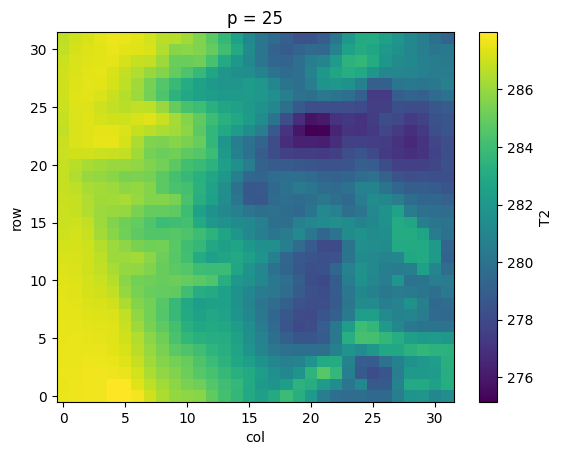

In [28]:
T.isel(p=25).plot()

How to create a timeseries plot over two locations using `matplotlib`

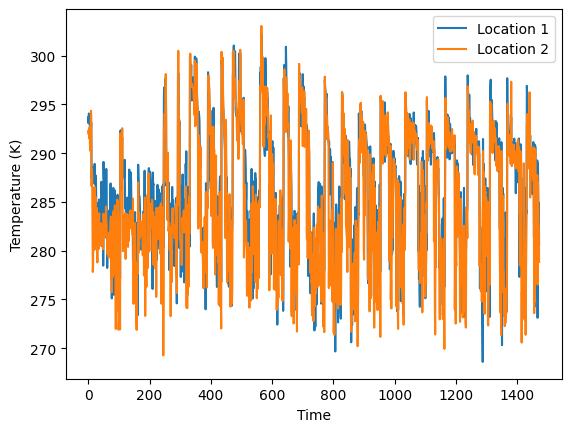

In [29]:
plt.plot(xf['p'],T[:,1,1], label='Location 1')
plt.plot(xf['p'],T[:,30,30], label='Location 2')
plt.ylabel('Temperature (K)')
plt.xlabel('Time')
plt.legend()

How to create a simple contour plot with `matplotlib`

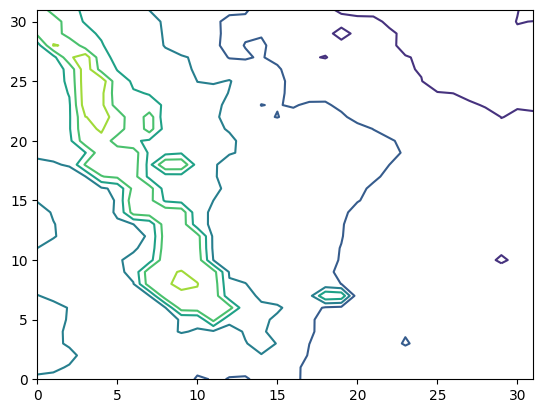

In [30]:
plt.contour(T[0,:,:])

Create the same plot as above, but use the `p` axis label provided by `xarray`

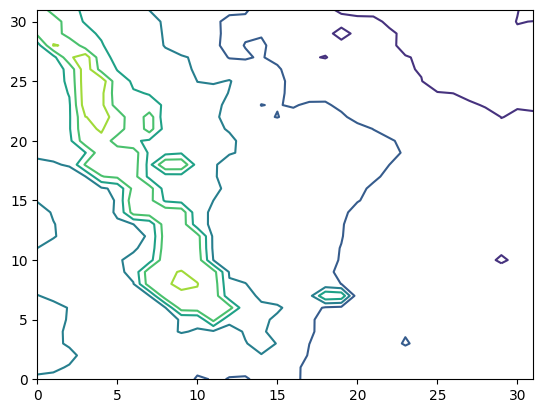

In [31]:
plt.contour(T.sel(p=0))

Same as above, but countour labels have been added

<a list of 10 text.Text objects>

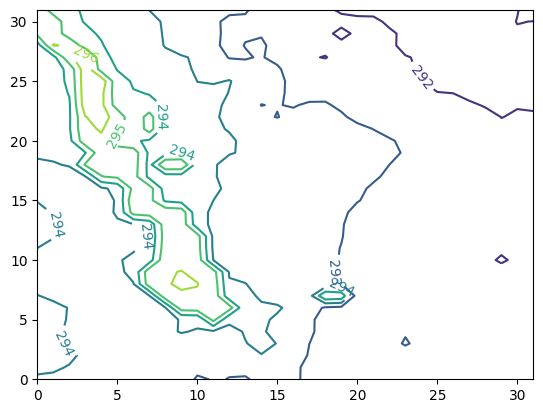

In [32]:
cs = plt.contour(T.sel(p=0))
plt.clabel(cs, fmt='%.0f', inline=True)

Plotting wind data

(useful for other vector fields e.g. water currents)

In [33]:
V = xf['V10_curr']  # V component
U = xf['U10_curr']  # U component
r = xf['row']       # Row indices
c = xf['col']       # Col indices

How to draw a countour plot with quivers

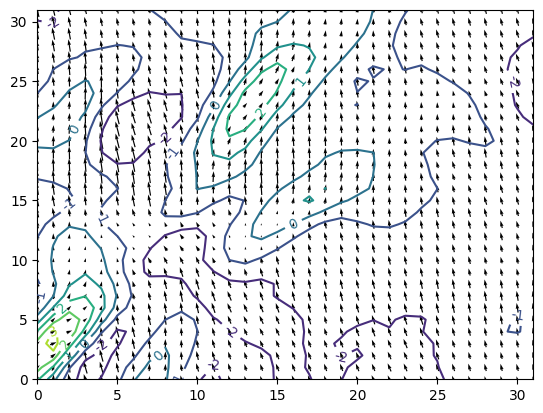

In [34]:
cs = plt.contour(U.sel(p=0))
plt.clabel(cs, fmt='%.0f', inline=True)
plt.quiver(r, c, U.sel(p=0), V.sel(p=0), pivot='middle')

How to draw a barb plot

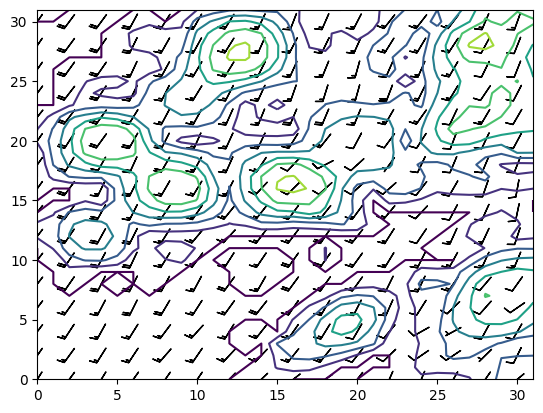

In [35]:
stride = 2
patch = 322
plt.contour(xf["REFL_COM_curr"].sel(p=patch))
plt.barbs(r[::stride], c[::stride], U.sel(p=patch)[::stride, ::stride],
          V.sel(p=200)[::stride, ::stride], length=5, pivot='middle')

## Extract data for ML

- ML training data can come from a variety of formats including `NetCDF`, `.csv`, `.geotiff`, and many more.
- But we feed generic arrays into ML training algorithms
- So we need to extract what we need and store it as `numpy` arrays that can be be used as input to ML algorithms
  - Either directly, or by first converting to whatever is required by the ML library. For example, `pythorch` uses its own `torch.Tensor` object which is easily created from a `Numpy` array.

Loop through each file and extract the relevant variables

In [36]:
# List of input variables
in_vars = ["REFL_COM_curr",
           "U10_curr", "V10_curr"]
# List of output variables
out_vars = ["RVORT1_MAX_future"]
in_data = []
out_data = []

for f in files:
    ds = xr.open_dataset(f)
    in_data.append(np.stack([ds[v].values for v in in_vars], axis=-1))
    out_data.append(np.stack([ds[v].values for v in out_vars], axis=-1))
    ds.close()

Stack the data into single arrays instead of lists of arrays

This is done to make it easier to feed the data into the ML algorithms

In [37]:
all_in_data = np.vstack(in_data)
all_out_data = np.vstack(out_data)

# Deallocate the lists of temporary arrays to save memory
del in_data[:], out_data[:]
del in_data, out_data

In [38]:
# Find maximum vorticity
max_vort = all_out_data[:, :, :, 0].max(axis=-1).max(axis=-1)
vort_thresh = 0.008
print(percentileofscore(max_vort, vort_thresh))
vort_labels = np.where(max_vort > vort_thresh, 1, 0)

97.47888754055326


**Plot storm image: combined channels**

In [39]:
# Index of sample with maximum vorticity
rot_ex = max_vort.argmax()

Text(0.5, 1.0, 'Storm Example 112218 Valid ')

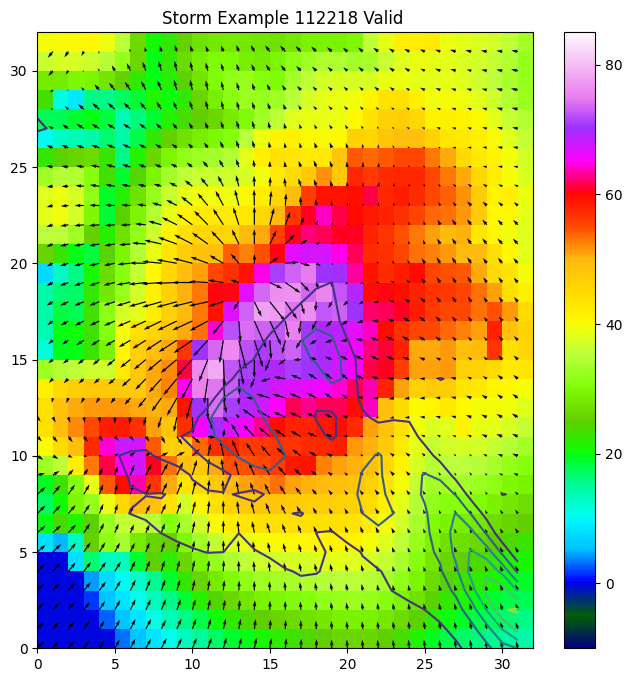

In [40]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(all_in_data[rot_ex, :, :, 0], cmap="gist_ncar", vmin=-10, vmax=85)
plt.colorbar()
plt.quiver(all_in_data[rot_ex, :, :, 1], all_in_data[rot_ex, :, :, 2])
plt.contour(all_out_data[rot_ex, :, :, 0])
plt.title("Storm Example {0} Valid ".format(rot_ex))

**Plot storm image: separate channels**

- Above, able to plot three channels as a single image
- This exploits that we can overlay the wind (2 channels) on the the reflectivity

In general, cannot view an arbitrary number of channels as a single 2D image

Below, we plot each band separaely without using any domain knowledge to customize the visualization

In [41]:
def plotChannels(data, index):
  # data: shape (samples, rows, cols, bands)
  # index: which sample to plot

  # Number of raster channels (a.k.a. bands)
  n_bands = data.shape[-1]

  fig, axs = plt.subplots(1, n_bands)
  for b_i in range(n_bands):
    axs[b_i].imshow(all_in_data[index, :, :, b_i])
    axs[b_i].set_axis_off()

Plot **highest vorticity** sample

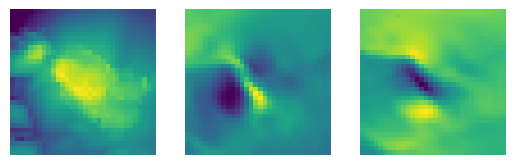

In [42]:
plotChannels(all_in_data, rot_ex)

Plot **lowest vorticity** sample

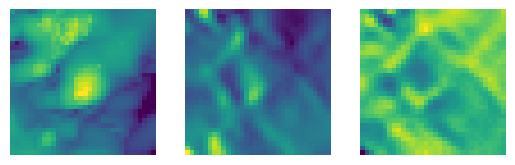

In [43]:
# Index of sample with maximum vorticity
min_vort = all_out_data[:, :, :, 0].min(axis=-1).min(axis=-1)
min_idx = min_vort.argmax()
plotChannels(all_in_data, min_idx)

Comparing the two above... its not very clear that the **max case** has stronger reflecitivty than the **min case**.

This is because all the variables are plotted where the max and min colors are based on each sample. We need to take the dataset into account.

In [44]:
def plotChannels_2(data, index):

  # Number of raster channels (a.k.a. bands)
  n_bands = data.shape[-1]

  # Find min, max of each band
  vminmax = np.vstack((
      np.min(data, axis=(0,1,2)),
      np.max(data, axis=(0,1,2))
      ))

  fig, axs = plt.subplots(1, n_bands)
  for b_i in range(n_bands):
    axs[b_i].imshow(data[index, :, :, b_i], vmin=vminmax[0, b_i], vmax=vminmax[1, b_i])
    axs[b_i].set_axis_off()

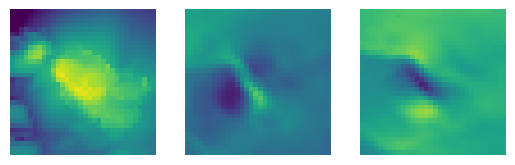

In [45]:
plotChannels_2(all_in_data, rot_ex)

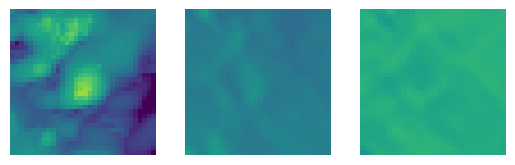

In [46]:
plotChannels_2(all_in_data, min_idx)

# Exercise: Select & Plot a Storm Image

**Task:** plot the multi-channel image of the storm with the **largest surface area** among all storms **below latitude 35°N**.

1. Filter the tabular dataframe to select only storms where `Centroid_Y` is below 35° North.
2. Among those, find the index of the storm with largest surface area using tabular feature `area`.
3. Use `plotchannels_2` to plot the `REFL_COM_curr` and `T2_curr` channels.

# Extract and plot a storm track

This part combines **tabular** and **raster** data to explore the dataset.

## Extract the longest storm track

There is time, storm track, and step ID all combined in one string

We can't easily do processing based on these values since they are combined

We need to separate them and add them as individual columns

In [47]:
index_str = df1["Step_ID"].values
index_str

array(['d01_REFL_COM_20101024-0000_12_12_000_00',
       'd01_REFL_COM_20101024-0000_12_12_001_00',
       'd01_REFL_COM_20101024-0000_12_15_002_00', ...,
       'd01_REFL_COM_20170329-0000_35_35_644_00',
       'd01_REFL_COM_20170329-0000_35_35_645_00',
       'd01_REFL_COM_20170329-0000_35_35_646_00'], dtype=object)

In [48]:
arrs = np.array([istr.split("_") for istr in index_str])
arrs

array([['d01', 'REFL', 'COM', ..., '12', '000', '00'],
       ['d01', 'REFL', 'COM', ..., '12', '001', '00'],
       ['d01', 'REFL', 'COM', ..., '15', '002', '00'],
       ...,
       ['d01', 'REFL', 'COM', ..., '35', '644', '00'],
       ['d01', 'REFL', 'COM', ..., '35', '645', '00'],
       ['d01', 'REFL', 'COM', ..., '35', '646', '00']], dtype='<U13')

In [49]:
df1["date"] = arrs[:, 3]
df1["track_id"] = arrs[:, 6]
df1["step_id"] = arrs[:, 7]
df1

,Step_ID,U10_mean,V10_mean,T2_mean,date,track_id,step_id
0,d01_REFL_COM_20101024-0000_12_12_000_00,0.19710,5.32790,293.14920,20101024-0000,000,00
1,d01_REFL_COM_20101024-0000_12_12_001_00,-1.03154,5.33612,292.00092,20101024-0000,001,00
2,d01_REFL_COM_20101024-0000_12_15_002_00,-0.21393,1.99015,293.00864,20101024-0000,002,00
3,d01_REFL_COM_20101024-0000_12_15_002_01,1.27862,1.81628,292.64368,20101024-0000,002,01
4,d01_REFL_COM_20101024-0000_12_15_002_02,0.88129,4.33189,292.39392,20101024-0000,002,02
...,...,...,...,...,...,...,...
121132,d01_REFL_COM_20170329-0000_35_35_642_00,-8.86706,-1.33135,273.58255,20170329-0000,642,00
121133,d01_REFL_COM_20170329-0000_35_35_643_00,-8.62868,-0.10351,272.14319,20170329-0000,643,00
121134,d01_REFL_COM_20170329-0000_35_35_644_00,-7.56922,-2.46200,272.73077,20170329-0000,644,00
121135,d01_REFL_COM_20170329-0000_35_35_645_00,-7.59599,-0.20326,272.96225,20170329-0000,645,00


Now we have columns that can be used to extract the longest track

Longest track means _largest number of step images_

In [50]:
# Examine the track IDs
tracks = df1["track_id"].values

Can we use Track IDs for reliably accessing individual tracks?

(As in: can we count repeats of track ID to count number of steps in each track?)

In [51]:
dates = df1["date"].values

In [52]:
datetracks = np.array([dates, tracks]).T
datetracks

array([['20101024-0000', '000'],
       ['20101024-0000', '001'],
       ['20101024-0000', '002'],
       ...,
       ['20170329-0000', '644'],
       ['20170329-0000', '645'],
       ['20170329-0000', '646']], dtype=object)

In [53]:
unique, counts = np.unique(datetracks, return_counts=True)

In [54]:
datetracks[datetracks[:,1] == '000']

array([['20101024-0000', '000'],
       ['20101122-0000', '000'],
       ['20101122-0000', '000'],
       ['20101122-0000', '000'],
       ['20101122-0000', '000'],
       ['20101122-0000', '000'],
       ['20110201-0000', '000'],
       ['20110308-0000', '000'],
       ['20110326-0000', '000'],
       ['20110326-0000', '000'],
       ['20110404-0000', '000'],
       ['20110414-0000', '000'],
       ['20110414-0000', '000'],
       ['20110420-0000', '000'],
       ['20110425-0000', '000'],
       ['20110425-0000', '000'],
       ['20110425-0000', '000'],
       ['20110425-0000', '000'],
       ['20110509-0000', '000'],
       ['20110509-0000', '000'],
       ['20110522-0000', '000'],
       ['20110527-0000', '000'],
       ['20110605-0000', '000'],
       ['20110610-0000', '000'],
       ['20110610-0000', '000'],
       ['20110610-0000', '000'],
       ['20110615-0000', '000'],
       ['20110620-0000', '000'],
       ['20110620-0000', '000'],
       ['20110625-0000', '000'],
       ['2

They can even repeat in the same day!

```
['20151031-0000', '000'],
['20151031-0000', '000'],
```

We need another way to select unique tracks and count how many steps each has

Idea: every time there is a `step_id` of `000`, it indicates a new track (and the end of the previous track)


In [55]:
# Find all track starts
track_starts = np.where(df1["step_id"] == "00")[0].astype("int")

In [56]:
# And subtract one to get track ends
track_ends = track_starts - 1

In [57]:
# Fix: the first track
track_ends[:-1] = track_ends[1:]

In [58]:
# Fix: last track ends with the last sample count
track_ends[-1] = len(df1) - 1

In [59]:
# Combine into array
track_bounds = np.array([track_starts, track_ends]).T
track_bounds

array([[     0,      0],
       [     1,      1],
       [     2,      5],
       ...,
       [121134, 121134],
       [121135, 121135],
       [121136, 121136]])

In [60]:
# Count the size of each track
n_steps = track_bounds[:,1] - track_bounds[:,0]
n_steps

array([0, 0, 3, ..., 0, 0, 0])

In [61]:
# But they at least have one step
n_steps = n_steps + 1
n_steps

array([1, 1, 4, ..., 1, 1, 1])

In [62]:
# Longest track
track_max_idx = np.argmax(n_steps)
track_max_val = n_steps[track_max_idx]
(track_max_idx, track_max_val)

(42212, 18)

In [63]:
# Access the track
t_start = track_bounds[track_max_idx, 0]
t_stop = track_bounds[track_max_idx, 1]

df_max = df1.loc[t_start:t_stop]
df_max

,Step_ID,U10_mean,V10_mean,T2_mean,date,track_id,step_id
77039,d01_REFL_COM_20150416-0000_17_34_131_00,-3.78011,3.24375,296.55890,20150416-0000,131,00
77040,d01_REFL_COM_20150416-0000_17_34_131_01,-3.47693,2.70294,295.88629,20150416-0000,131,01
77041,d01_REFL_COM_20150416-0000_17_34_131_02,-2.67922,1.58790,295.39749,20150416-0000,131,02
77042,d01_REFL_COM_20150416-0000_17_34_131_03,-2.70202,-2.24652,295.08102,20150416-0000,131,03
77043,d01_REFL_COM_20150416-0000_17_34_131_04,2.17380,-2.84859,293.84500,20150416-0000,131,04
77044,d01_REFL_COM_20150416-0000_17_34_131_05,-1.07224,-3.64918,294.09204,20150416-0000,131,05
77045,d01_REFL_COM_20150416-0000_17_34_131_06,-2.08008,-1.65006,293.52142,20150416-0000,131,06
77046,d01_REFL_COM_20150416-0000_17_34_131_07,-1.78520,1.18987,292.85760,20150416-0000,131,07
77047,d01_REFL_COM_20150416-0000_17_34_131_08,-0.60511,-2.81697,293.52896,20150416-0000,131,08
77048,d01_REFL_COM_20150416-0000_17_34_131_09,-0.37164,-4.01358,292.58597,20150416-0000,131,09


**Plot the track**

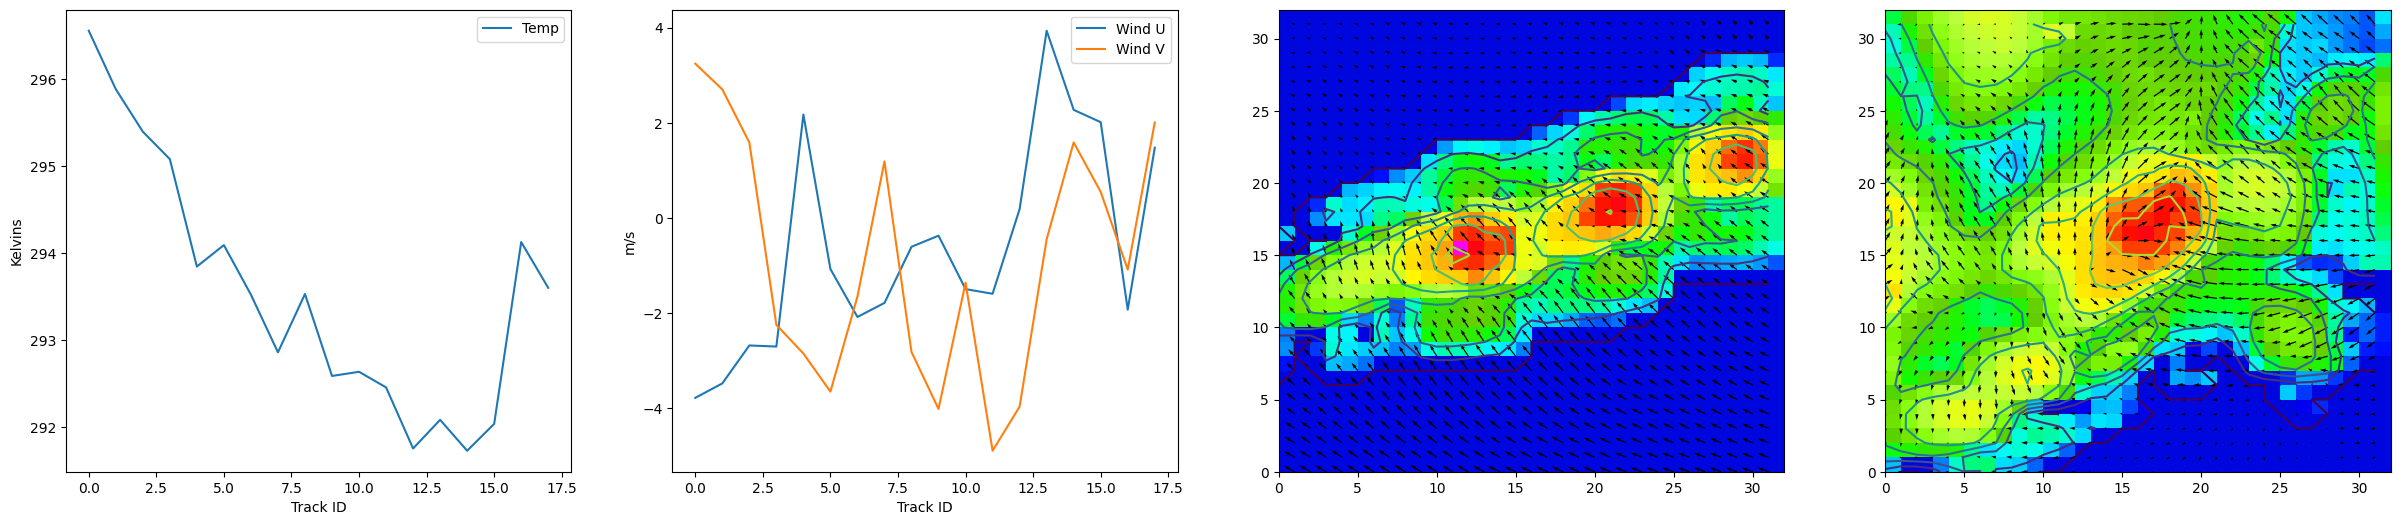

In [64]:
fig, axs = plt.subplots(1,4, figsize=(30,6))

axs[0].plot(df_max["T2_mean"].values)
axs[0].set_ylabel("Kelvins")
axs[0].set_xlabel("Track ID")
axs[0].legend(["Temp"])

axs[1].plot(df_max["U10_mean"].values)
axs[1].plot(df_max["V10_mean"].values)
axs[1].set_ylabel("m/s")
axs[1].set_xlabel("Track ID")
axs[1].legend(["Wind U", "Wind V"])

def plotmap(idx, data, ax):
  ax.pcolormesh(data[idx, :, :, 0], cmap="gist_ncar", vmin=-10, vmax=85)
  # ax[2].colorbar()
  ax.quiver(data[idx, :, :, 1], data[idx, :, :, 2])
  ax.contour(data[idx, :, :, 0])

plotmap(t_start, all_in_data, axs[2])
plotmap(t_stop, all_in_data, axs[3])

**Plot the entire track sequence**

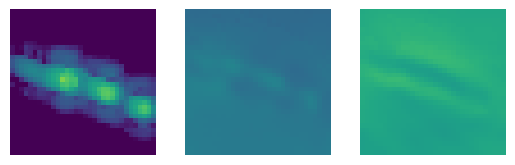

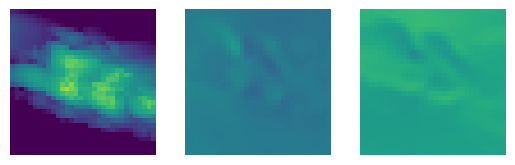

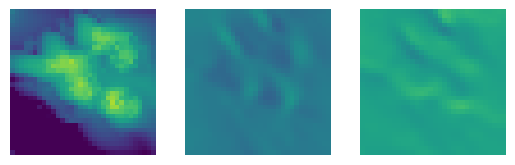

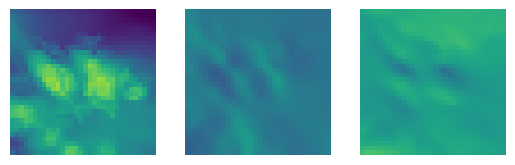

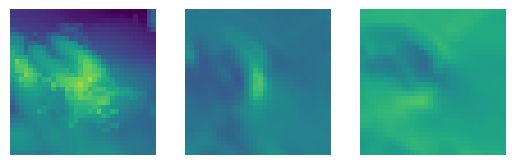

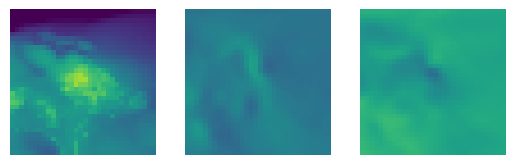

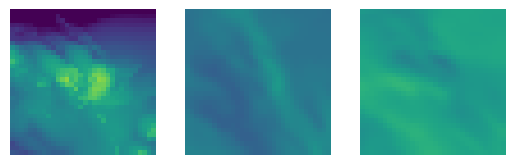

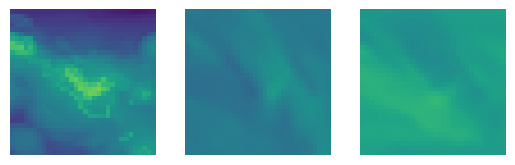

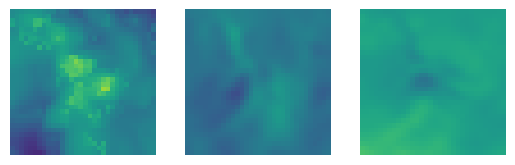

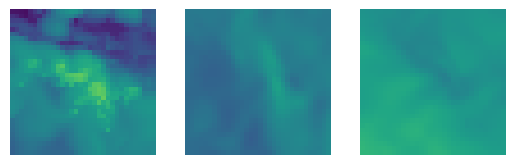

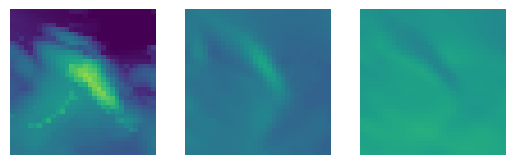

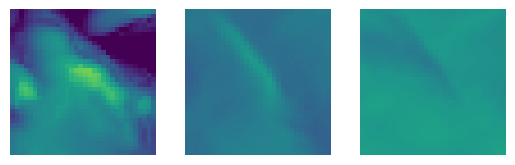

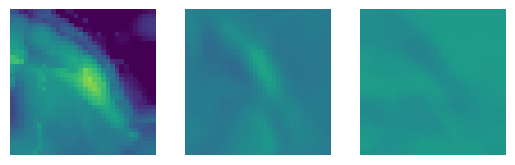

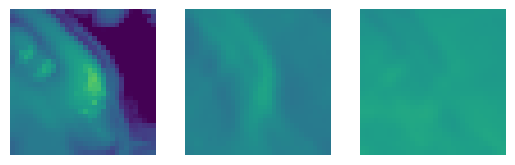

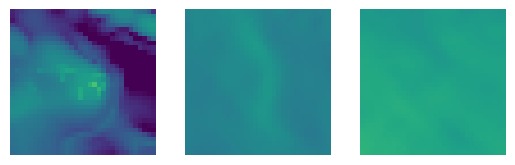

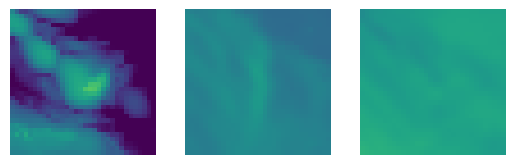

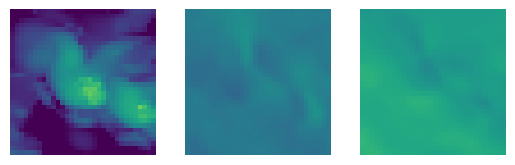

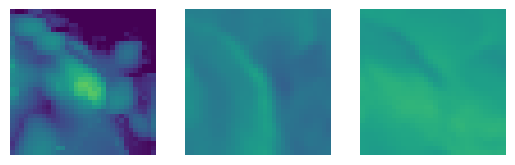

In [65]:
for step_idx in range(t_start, t_stop + 1):
  plotChannels_2(all_in_data, step_idx)

## Plot the geographic storm track

In [66]:
df2 = df1.copy()
df2["Centroid_Lon"] = df["Centroid_Lon"]
df2["Centroid_Lat"] = df["Centroid_Lat"]
df2

,Step_ID,U10_mean,V10_mean,T2_mean,date,track_id,step_id,Centroid_Lon,Centroid_Lat
0,d01_REFL_COM_20101024-0000_12_12_000_00,0.19710,5.32790,293.14920,20101024-0000,000,00,-93.43888,31.44266
1,d01_REFL_COM_20101024-0000_12_12_001_00,-1.03154,5.33612,292.00092,20101024-0000,001,00,-93.06068,32.33814
2,d01_REFL_COM_20101024-0000_12_15_002_00,-0.21393,1.99015,293.00864,20101024-0000,002,00,-93.65033,32.43676
3,d01_REFL_COM_20101024-0000_12_15_002_01,1.27862,1.81628,292.64368,20101024-0000,002,01,-93.28486,32.61097
4,d01_REFL_COM_20101024-0000_12_15_002_02,0.88129,4.33189,292.39392,20101024-0000,002,02,-92.73067,32.97272
...,...,...,...,...,...,...,...,...,...
121132,d01_REFL_COM_20170329-0000_35_35_642_00,-8.86706,-1.33135,273.58255,20170329-0000,642,00,-90.61781,44.29155
121133,d01_REFL_COM_20170329-0000_35_35_643_00,-8.62868,-0.10351,272.14319,20170329-0000,643,00,-85.65714,43.95582
121134,d01_REFL_COM_20170329-0000_35_35_644_00,-7.56922,-2.46200,272.73077,20170329-0000,644,00,-88.61868,44.33497
121135,d01_REFL_COM_20170329-0000_35_35_645_00,-7.59599,-0.20326,272.96225,20170329-0000,645,00,-86.29732,44.10219


In [67]:
df_geomax = df2.loc[t_start:t_stop]
df_geomax

,Step_ID,U10_mean,V10_mean,T2_mean,date,track_id,step_id,Centroid_Lon,Centroid_Lat
77039,d01_REFL_COM_20150416-0000_17_34_131_00,-3.78011,3.24375,296.55890,20150416-0000,131,00,-94.45620,29.93129
77040,d01_REFL_COM_20150416-0000_17_34_131_01,-3.47693,2.70294,295.88629,20150416-0000,131,01,-94.34106,30.20829
77041,d01_REFL_COM_20150416-0000_17_34_131_02,-2.67922,1.58790,295.39749,20150416-0000,131,02,-94.31775,30.50385
77042,d01_REFL_COM_20150416-0000_17_34_131_03,-2.70202,-2.24652,295.08102,20150416-0000,131,03,-94.07998,30.43122
77043,d01_REFL_COM_20150416-0000_17_34_131_04,2.17380,-2.84859,293.84500,20150416-0000,131,04,-93.71006,30.50489
77044,d01_REFL_COM_20150416-0000_17_34_131_05,-1.07224,-3.64918,294.09204,20150416-0000,131,05,-93.42279,30.50166
77045,d01_REFL_COM_20150416-0000_17_34_131_06,-2.08008,-1.65006,293.52142,20150416-0000,131,06,-93.24448,30.61754
77046,d01_REFL_COM_20150416-0000_17_34_131_07,-1.78520,1.18987,292.85760,20150416-0000,131,07,-92.88450,30.87813
77047,d01_REFL_COM_20150416-0000_17_34_131_08,-0.60511,-2.81697,293.52896,20150416-0000,131,08,-92.01300,31.27432
77048,d01_REFL_COM_20150416-0000_17_34_131_09,-0.37164,-4.01358,292.58597,20150416-0000,131,09,-91.86923,31.05874


In [68]:
# Get plotting boundaries to zoom in on the track
min_lat = np.min(df_geomax["Centroid_Lat"])
max_lat = np.max(df_geomax["Centroid_Lat"])
min_lon = np.min(df_geomax["Centroid_Lon"])
max_lon = np.max(df_geomax["Centroid_Lon"])
(min_lat, max_lat, min_lon, max_lon)

(29.93129, 31.27432, -94.4562, -89.39808)

Text(0.5, 1.0, 'Longest storm track  (20150416-0000)')

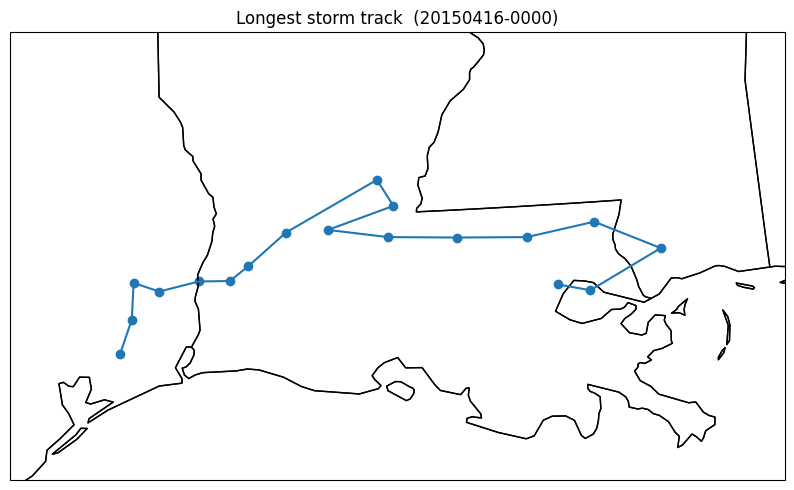

In [69]:
proj = ccrs.LambertConformal()
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=proj)
countries = cfeature.NaturalEarthFeature("cultural", "admin_0_countries", "50m", facecolor="None", edgecolor="k")
states = cfeature.NaturalEarthFeature("cultural", "admin_1_states_provinces", "50m", facecolor="None", edgecolor="k")
ax.add_feature(countries)
ax.add_feature(states)

out_points = proj.transform_points(ccrs.PlateCarree(),
                            df_geomax["Centroid_Lon"].values, df_geomax["Centroid_Lat"].values)

bound_points = proj.transform_points(proj, np.array([max_lon, min_lon]), np.array([min_lat, max_lat]),)
ax.set_extent([180 + max_lon + 1, 180 + min_lon - 1, min_lat - 1, max_lat + 1], crs=ccrs.PlateCarree(central_longitude=180))

plt.colorbar(out[-1])
ax.plot(out_points[:,0], out_points[:,1])
ax.scatter(out_points[:,0], out_points[:,1])

# Date
date = df1["date"].loc[t_start]
plt.title("Longest storm track  ({})".format(date))